In [414]:
import os

In [415]:
import polars as pl
from pathlib import Path

In [416]:
DATA_DIR = Path("data/lahman_1871-2024_csv")

pitch = pl.read_csv(DATA_DIR / "Pitching.csv")

# Filter for modern era
pitch_modern = pitch.filter(pl.col("yearID") >= 1946)

# Aggregate runs + outs per year & league
era_group = (
    pitch_modern
    .group_by(["yearID", "lgID"])
    .agg([
        pl.col("R").sum().alias("total_R"),
        pl.col("IPouts").sum().alias("total_IPouts"),
    ])
    .with_columns(
        (pl.col("total_R") / pl.col("total_IPouts") * 27).alias("ERA")
    )
)

era_group.head()

yearID,lgID,total_R,total_IPouts,ERA
i64,str,i64,i64,f64
1973,"""NL""",8062,52446,4.15044
2015,"""NL""",10225,65140,4.238179
2007,"""NL""",12388,69742,4.795905
1954,"""AL""",5203,33315,4.216749
1986,"""AL""",10449,60610,4.654727


In [417]:
bat = pl.read_csv(DATA_DIR / "Batting.csv")

bat_modern = bat.filter(pl.col("yearID") >= 1946)

bat_group = (
    bat_modern
    .group_by(["yearID", "lgID"])
    .agg([
        pl.col("AB").sum().alias("total_AB"),
        pl.col("H").sum().alias("total_H"),
        pl.col("2B").sum().alias("total_2B"),
        pl.col("3B").sum().alias("total_3B"),
        pl.col("HR").sum().alias("total_HR"),
    ])
    .with_columns([
        # total bases = H + 2B + 2*3B + 3*HR
        (pl.col("total_H") + pl.col("total_2B") + 2*pl.col("total_3B") + 3*pl.col("total_HR")).alias("total_TB"),
    ])
    .with_columns([
        (pl.col("total_TB") / pl.col("total_AB")).alias("SLG")
    ])
)

bat_group.head()


yearID,lgID,total_AB,total_H,total_2B,total_3B,total_HR,total_TB,SLG
i64,str,i64,i64,i64,i64,i64,i64,f64
2024,"""NL""",82127,20272,3963,360,2739,33172,0.403911
1994,"""NL""",55068,14695,2784,377,1532,22829,0.41456
1996,"""AL""",79090,21922,4205,421,2742,35195,0.444999
1957,"""AL""",41987,10703,1663,307,1024,16052,0.382309
1950,"""NL""",42416,11085,1885,370,1100,17010,0.401028


In [418]:
# import polars as pl

def dh_state_expr():
    return (
        pl.when(pl.col("yearID") < 1973)
          .then(pl.lit("No DH (both)"))
          .when((pl.col("yearID").is_between(1973, 2019)) & (pl.col("lgID") == "AL"))
          .then(pl.lit("DH in AL; NL no DH"))
          .when((pl.col("yearID").is_between(1973, 2019)) & (pl.col("lgID") == "NL"))
          .then(pl.lit("NL no DH"))
          .when(pl.col("yearID") == 2020)
          .then(pl.lit("Universal DH (2020)"))
          .when((pl.col("yearID") == 2021) & (pl.col("lgID") == "AL"))
          .then(pl.lit("DH in AL; NL no DH"))
          .when((pl.col("yearID") == 2021) & (pl.col("lgID") == "NL"))
          .then(pl.lit("NL no DH"))
          .when(pl.col("yearID") >= 2022)
          .then(pl.lit("Universal DH (2022+)"))
          .otherwise(pl.lit("Unknown"))
          .alias("DH_state")
    )


In [419]:
era_group = era_group.with_columns(dh_state_expr())
bat_group = bat_group.with_columns(dh_state_expr())

era_group.write_csv(DATA_DIR / "league_era_by_year.csv")
bat_group.write_csv(DATA_DIR / "league_slugging_by_year.csv")


In [420]:
# Check saved ERA file
pl.read_csv(DATA_DIR / "league_era_by_year.csv").head()


yearID,lgID,total_R,total_IPouts,ERA,DH_state
i64,str,i64,i64,f64,str
1973,"""NL""",8062,52446,4.15044,"""NL no DH"""
2015,"""NL""",10225,65140,4.238179,"""NL no DH"""
2007,"""NL""",12388,69742,4.795905,"""NL no DH"""
1954,"""AL""",5203,33315,4.216749,"""No DH (both)"""
1986,"""AL""",10449,60610,4.654727,"""DH in AL; NL no DH"""


In [421]:
# Check saved Slugging file
pl.read_csv(DATA_DIR / "league_slugging_by_year.csv").head()


yearID,lgID,total_AB,total_H,total_2B,total_3B,total_HR,total_TB,SLG,DH_state
i64,str,i64,i64,i64,i64,i64,i64,f64,str
2024,"""NL""",82127,20272,3963,360,2739,33172,0.403911,"""Universal DH (2022+)"""
1994,"""NL""",55068,14695,2784,377,1532,22829,0.41456,"""NL no DH"""
1996,"""AL""",79090,21922,4205,421,2742,35195,0.444999,"""DH in AL; NL no DH"""
1957,"""AL""",41987,10703,1663,307,1024,16052,0.382309,"""No DH (both)"""
1950,"""NL""",42416,11085,1885,370,1100,17010,0.401028,"""No DH (both)"""


<h1><b>Starting the part of lab2.1</b></h1>

Trying to create the graph that was in the picture

In [422]:
print(era_group.columns)
print(era_group.head(5))


['yearID', 'lgID', 'total_R', 'total_IPouts', 'ERA', 'DH_state']
shape: (5, 6)
┌────────┬──────┬─────────┬──────────────┬──────────┬────────────────────┐
│ yearID ┆ lgID ┆ total_R ┆ total_IPouts ┆ ERA      ┆ DH_state           │
│ ---    ┆ ---  ┆ ---     ┆ ---          ┆ ---      ┆ ---                │
│ i64    ┆ str  ┆ i64     ┆ i64          ┆ f64      ┆ str                │
╞════════╪══════╪═════════╪══════════════╪══════════╪════════════════════╡
│ 1973   ┆ NL   ┆ 8062    ┆ 52446        ┆ 4.15044  ┆ NL no DH           │
│ 2015   ┆ NL   ┆ 10225   ┆ 65140        ┆ 4.238179 ┆ NL no DH           │
│ 2007   ┆ NL   ┆ 12388   ┆ 69742        ┆ 4.795905 ┆ NL no DH           │
│ 1954   ┆ AL   ┆ 5203    ┆ 33315        ┆ 4.216749 ┆ No DH (both)       │
│ 1986   ┆ AL   ┆ 10449   ┆ 60610        ┆ 4.654727 ┆ DH in AL; NL no DH │
└────────┴──────┴─────────┴──────────────┴──────────┴────────────────────┘


In [423]:
# --- ensure all year/league combos exist ---
years = era_group.select("yearID").unique().to_series().to_list()
leagues = era_group.select("lgID").unique().to_series().to_list()

all_years_leagues = (
    pl.DataFrame({"yearID": years})
    .join(pl.DataFrame({"lgID": leagues}), how="cross")
)

# join back to era_group to fill missing with nulls
era_full = (
    all_years_leagues
    .join(era_group, on=["yearID", "lgID"], how="left")
)

# --- pivot wide to get AL/NL side by side ---
era_wide = (
    era_full
    .pivot(index="yearID", columns="lgID", values="ERA")
    .sort("yearID")
)

# --- compute AL - NL difference ---
era_wide = era_wide.with_columns(
    (pl.col("AL") - pl.col("NL")).alias("AL-NL")
)

# --- melt back to long form for plotting ---
era_long = (
    era_wide
    .melt(id_vars="yearID", value_vars=["AL", "NL", "AL-NL"],
          variable_name="league", value_name="ERA")
    .sort(["yearID", "league"])
)

# stats for annotations
era_mean = float(era_long["ERA"].mean())
era_ymax = float(era_long["ERA"].max())

print(era_long.head(10))



shape: (10, 3)
┌────────┬────────┬───────────┐
│ yearID ┆ league ┆ ERA       │
│ ---    ┆ ---    ┆ ---       │
│ i64    ┆ str    ┆ f64       │
╞════════╪════════╪═══════════╡
│ 1946   ┆ AL     ┆ 4.098084  │
│ 1946   ┆ AL-NL  ┆ 0.105     │
│ 1946   ┆ NL     ┆ 3.993084  │
│ 1947   ┆ AL     ┆ 4.193662  │
│ 1947   ┆ AL-NL  ┆ -0.458426 │
│ 1947   ┆ NL     ┆ 4.652088  │
│ 1948   ┆ AL     ┆ 4.786844  │
│ 1948   ┆ AL-NL  ┆ 0.289993  │
│ 1948   ┆ NL     ┆ 4.496851  │
│ 1949   ┆ AL     ┆ 4.751302  │
└────────┴────────┴───────────┘


C:\Users\im4284hw\AppData\Local\Temp\ipykernel_25772\4189582116.py:19: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
C:\Users\im4284hw\AppData\Local\Temp\ipykernel_25772\4189582116.py:31: DeprecationWarning: `DataFrame.melt` is deprecated; use `DataFrame.unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`


In [424]:
# importing pyarrow so I do not have to use pandas
import pyarrow
print(pyarrow.__version__)


21.0.0


In [425]:
# use pyarrow extension
era_pd = era_long.to_pandas(use_pyarrow_extension_array=True)


In [426]:
# DH milestone years and labels
dh_years = [1973, 2020, 2022]
dh_labels = {
    1973: "AL adopts DH (1973)",
    2020: "NL uses DH (2020)",
    2022: "Universal DH (2022)"
}

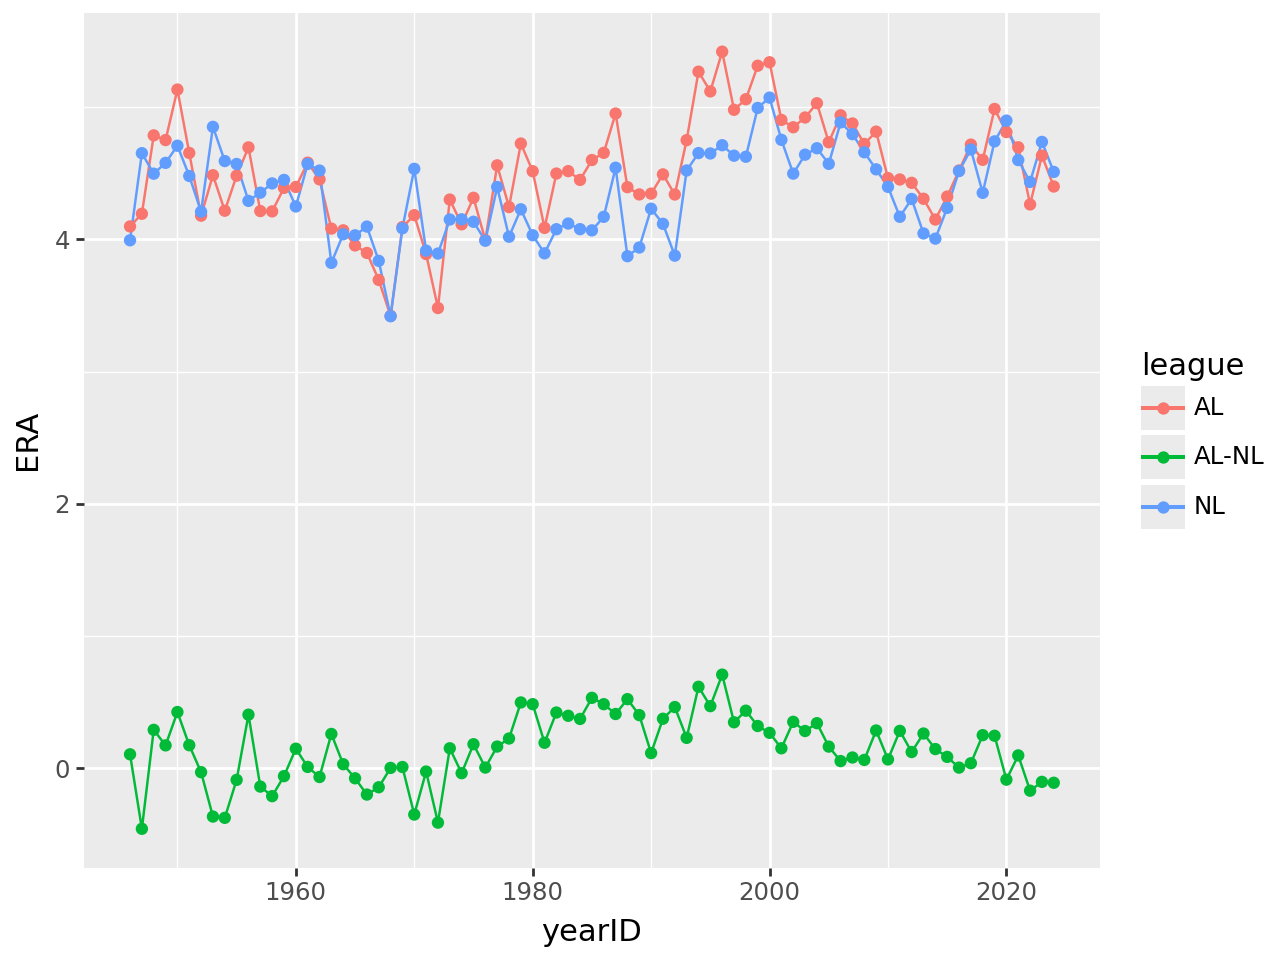

In [427]:

from plotnine import ggplot, aes, geom_line, geom_point

# start simple
# Making the basic plot
p_era = ggplot(era_pd, aes(x="yearID", y="ERA", color="league", group="league"))
p_era = p_era + geom_line()
p_era = p_era + geom_point()
p_era

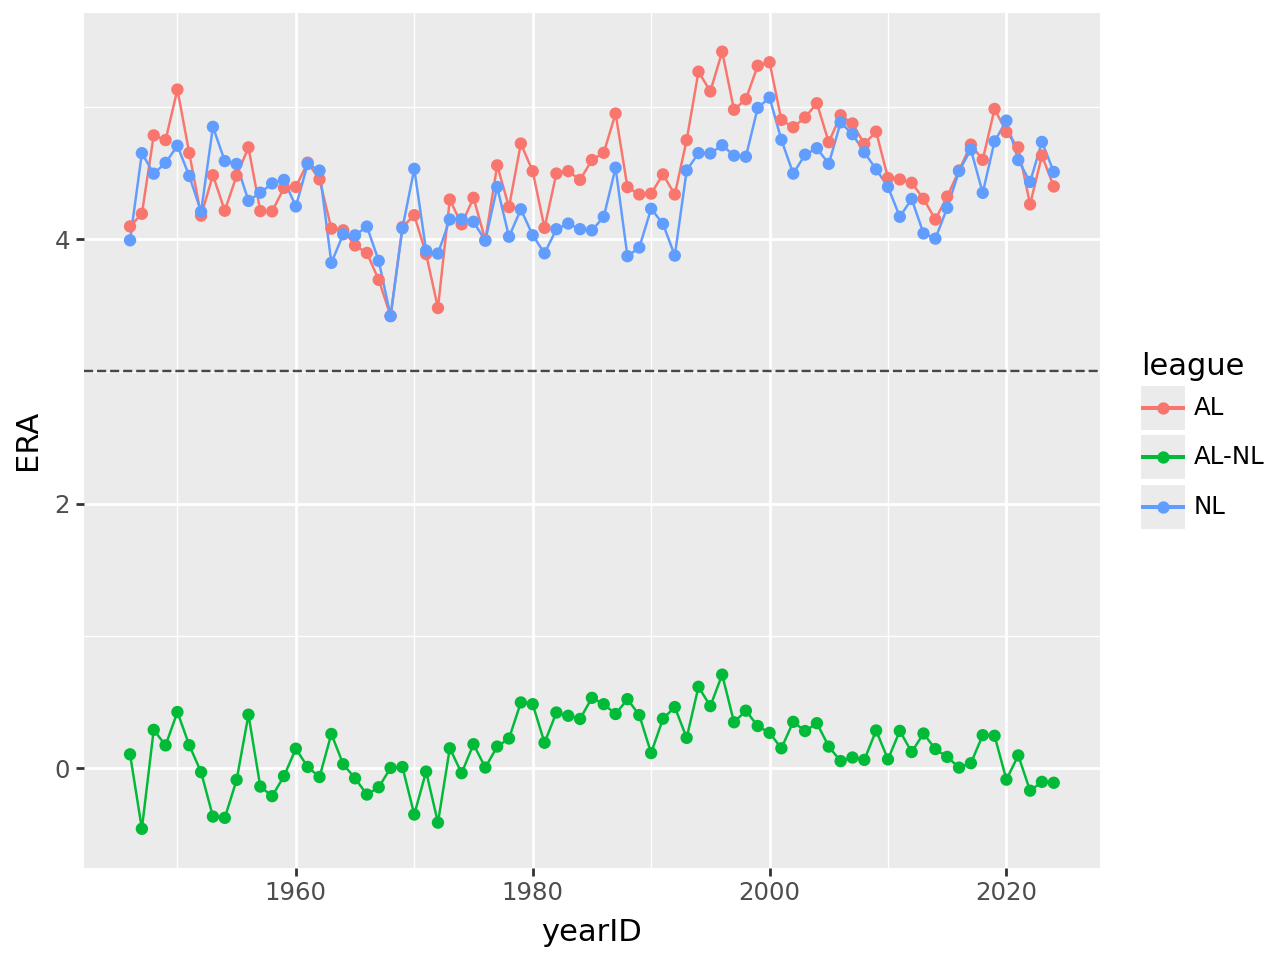

In [428]:
# adding the horizontal mean line 

from plotnine import geom_hline

p_era = p_era + geom_hline(yintercept=era_mean, linetype="dashed", alpha=0.7)
p_era

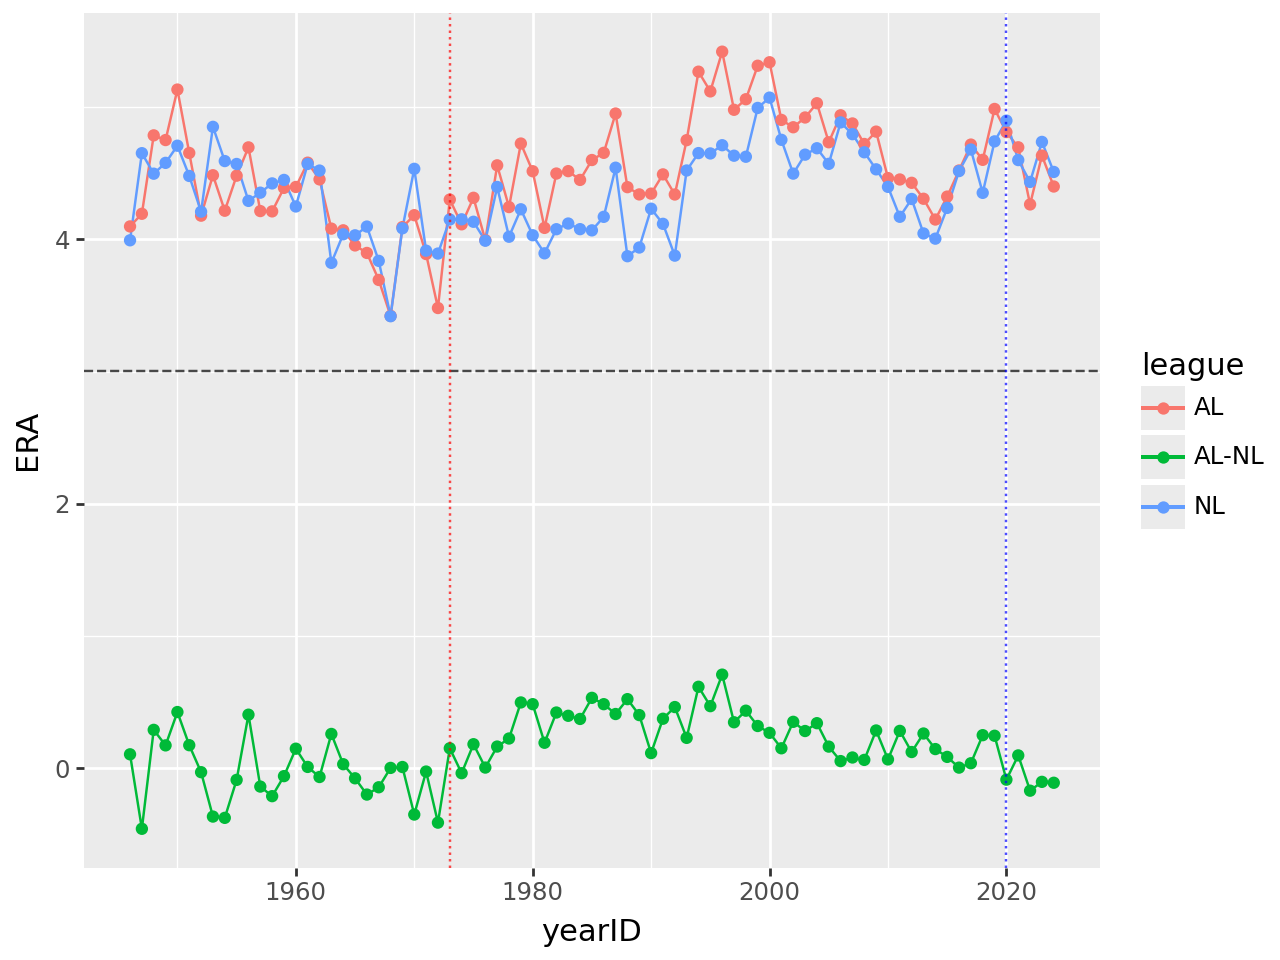

In [429]:
# adding the vertical lines to indicate DH rule changes

from plotnine import geom_vline

# for AL line (1973) in red
p_era = p_era + geom_vline(xintercept=1973, linetype="dotted", alpha=0.7, color="red")

# for NL line (2020) in blue
p_era = p_era + geom_vline(xintercept=2020, linetype="dotted", alpha=0.7, color="blue")

p_era



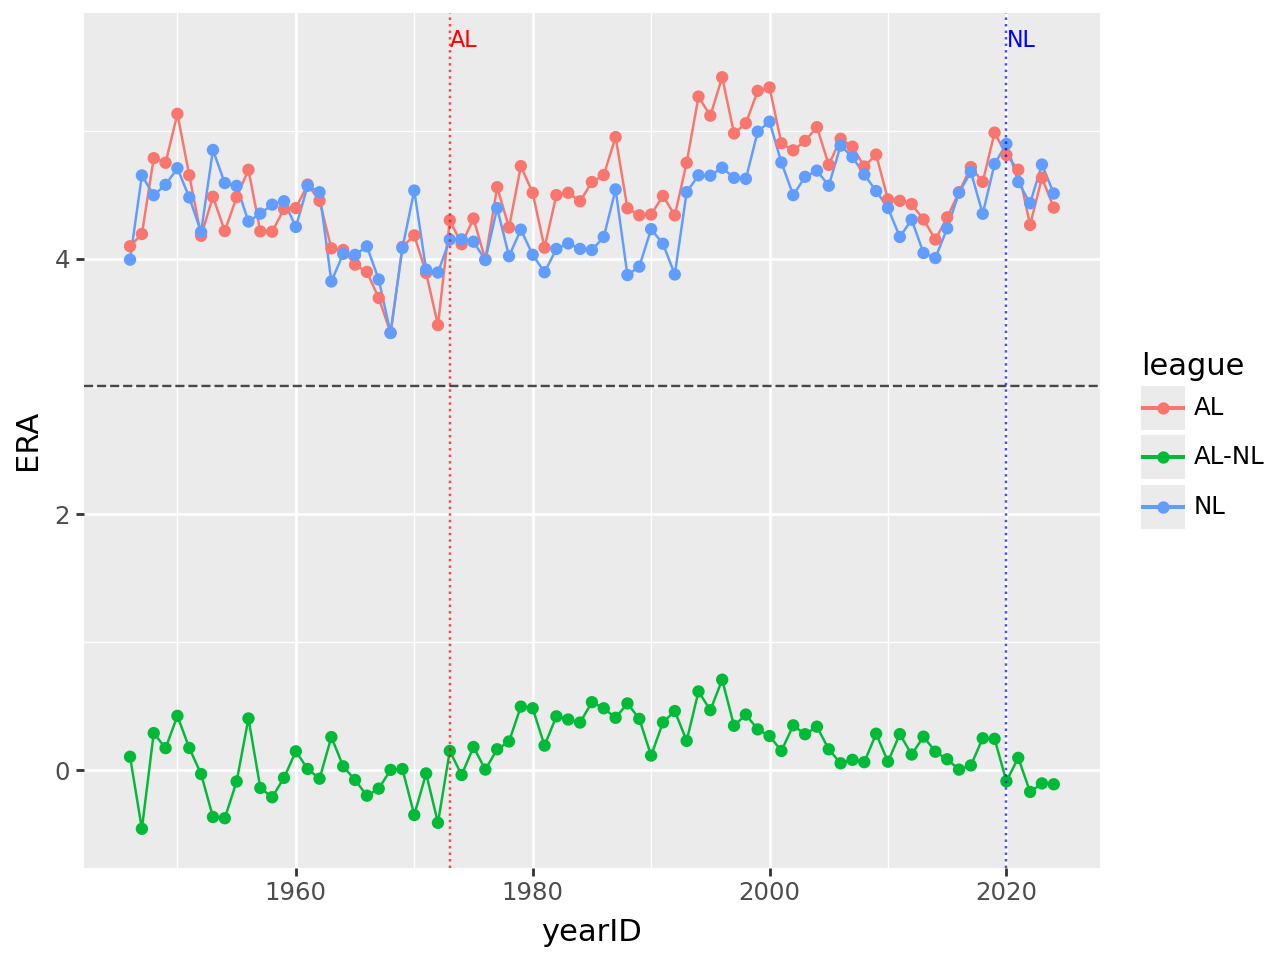

In [430]:
# Addading annotations to indicate what the vertical lines and rule change
from plotnine import annotate

p_era = p_era + annotate("text", x=1973, y=era_ymax + 0.2, label="AL", angle=0, ha="left", va="bottom", size=8, color="Red" )
p_era = p_era + annotate("text", x=2020, y=era_ymax + 0.2, label="NL", angle=0, ha="left", va="bottom", size=8, color="Blue")
p_era


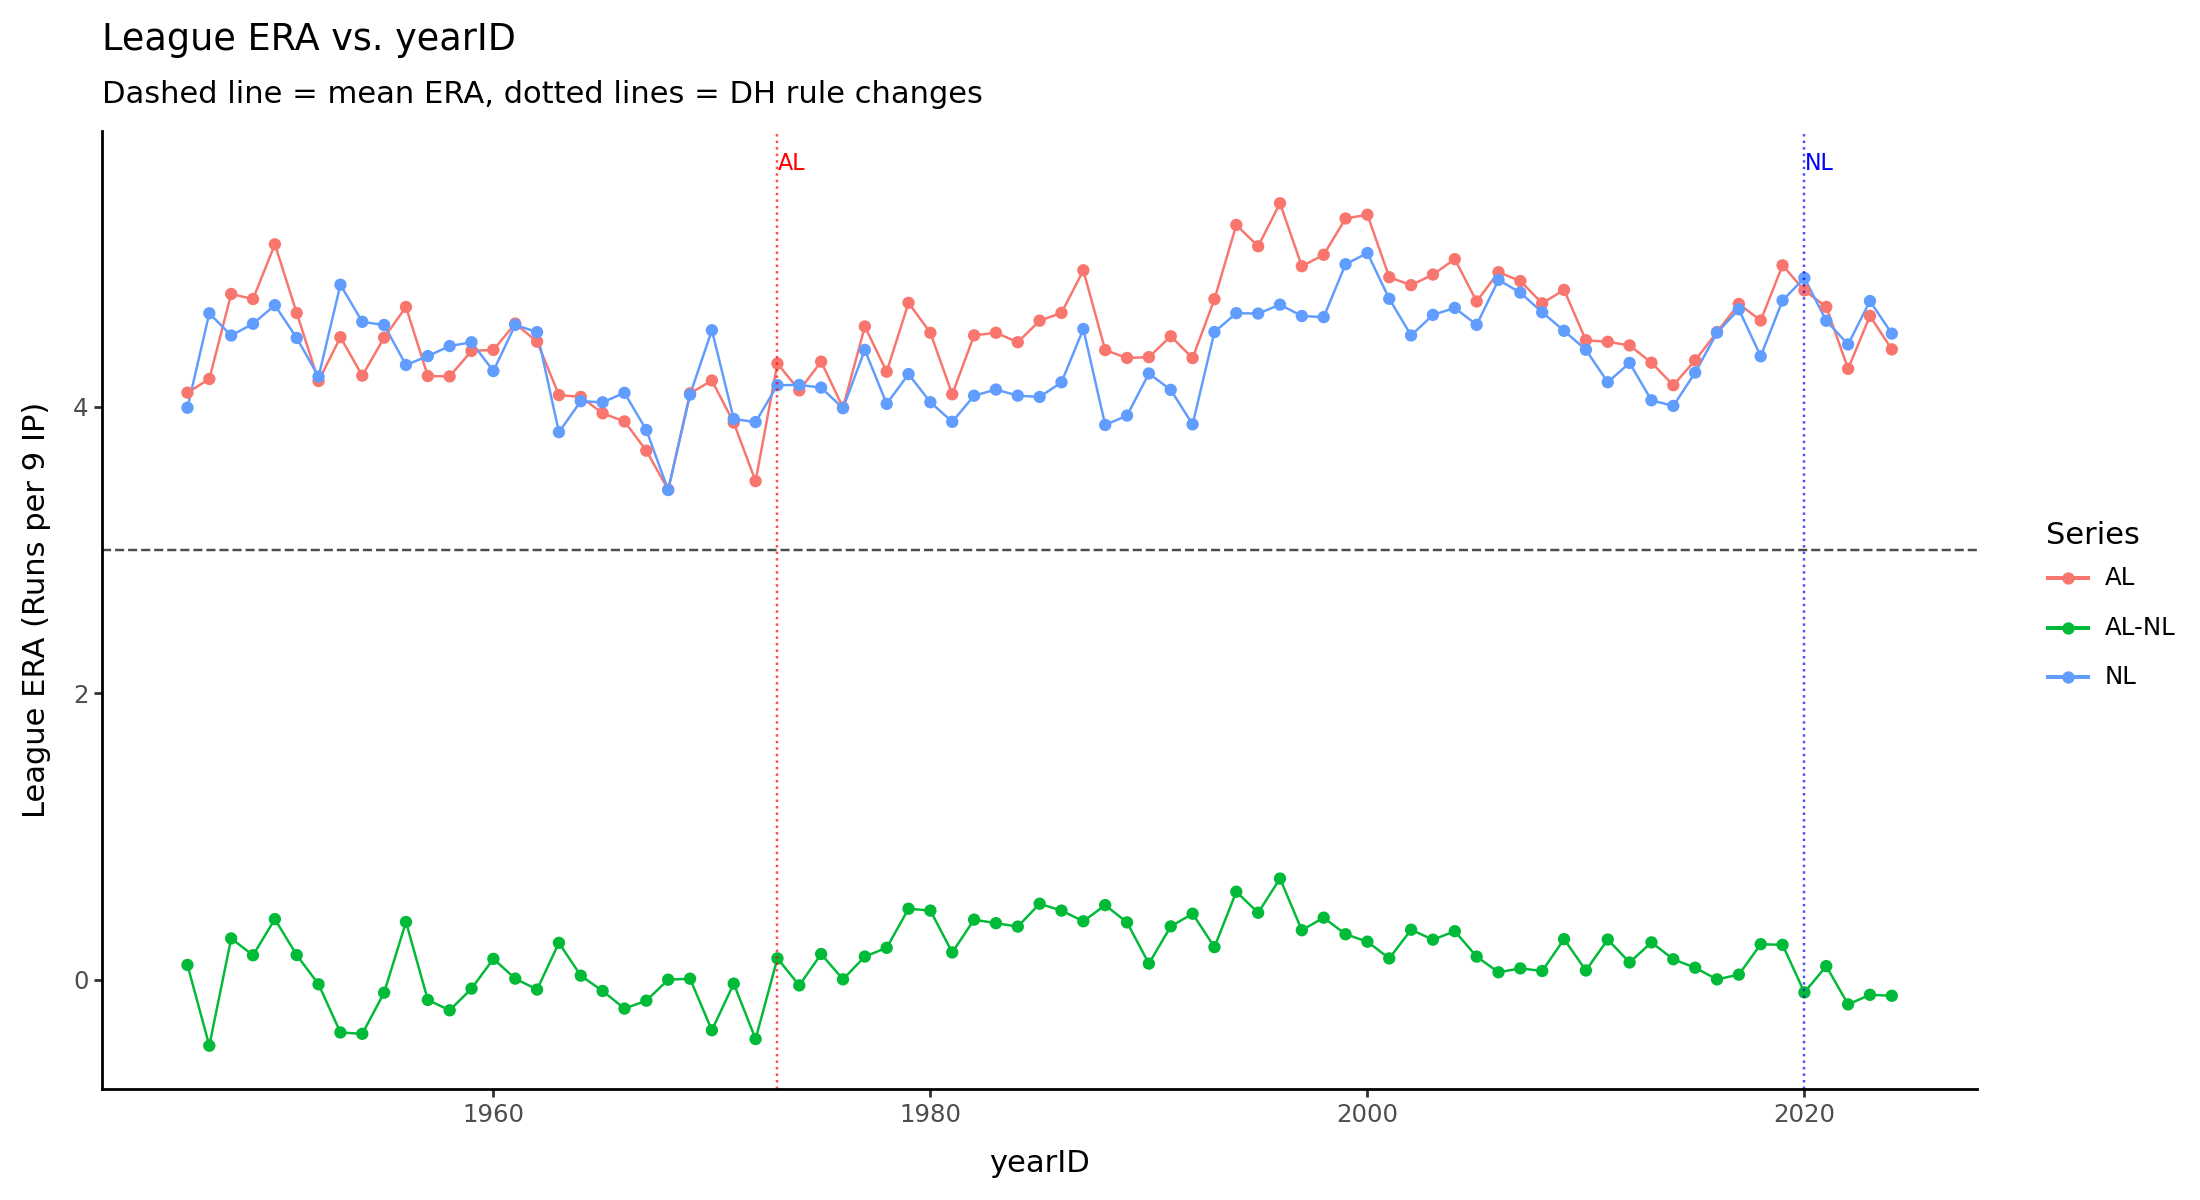

In [431]:
# Adding labels and themes ans size ratio 

from plotnine import labs, theme_classic, theme

p_era = p_era + labs(
    title="League ERA vs. yearID",
    subtitle="Dashed line = mean ERA, dotted lines = DH rule changes",  #this was not in your example but I added it ot make it more documented
    x="yearID",   # x axis label
    y="League ERA (Runs per 9 IP)",  # y axis label and here the IP means innings pitched
    color="Series"
)
p_era = p_era + theme_classic() # applying a classic theme
p_era = p_era + theme(figure_size=(11, 6))  # adjusting the size ratio
p_era


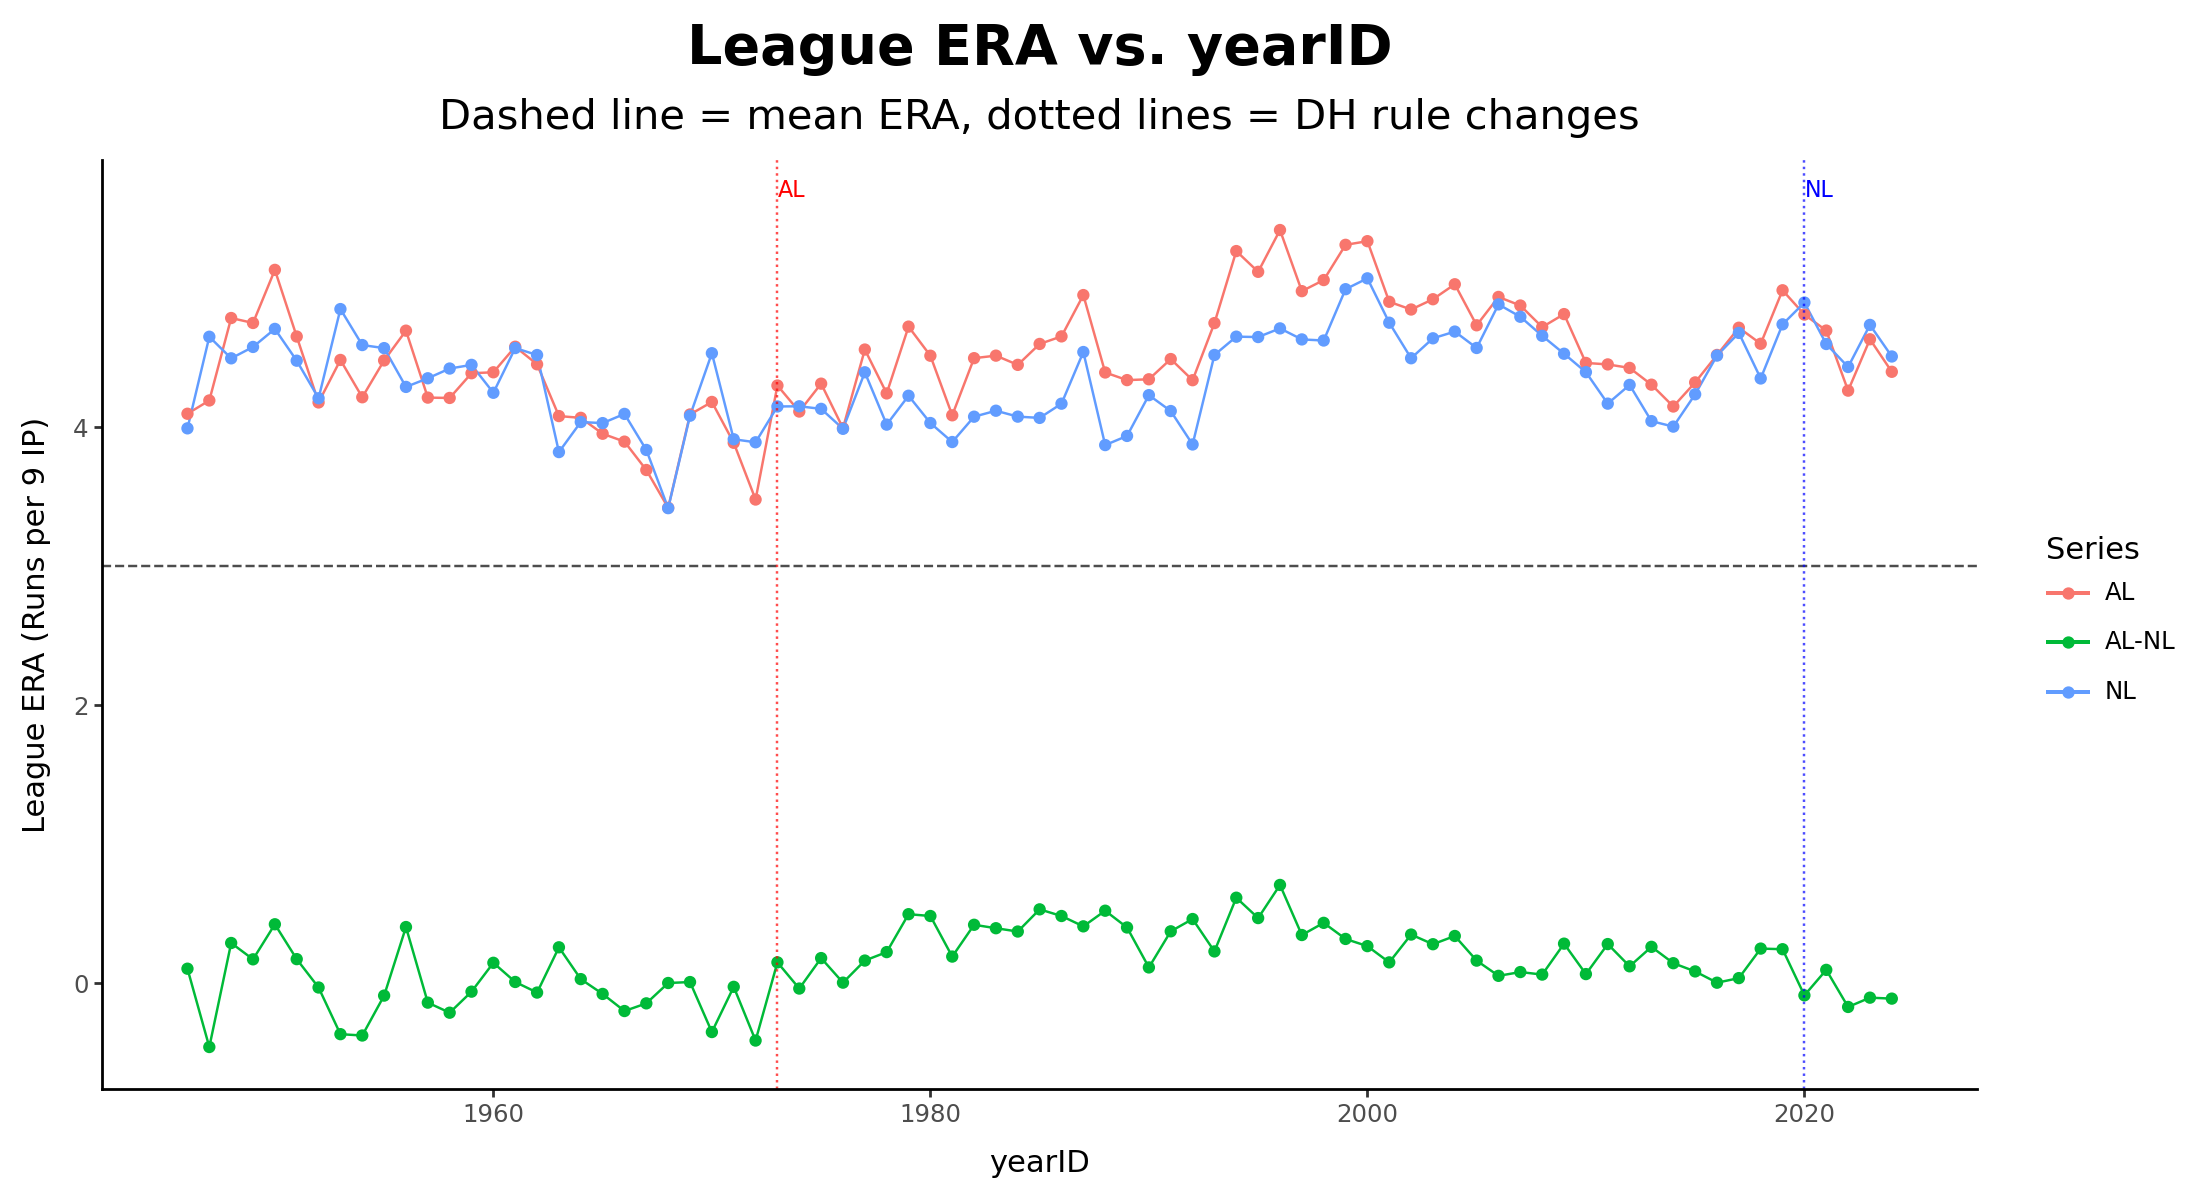

In [432]:
# Wanted the header to be centered and bigger
from plotnine import element_text

p_era = p_era + theme(
    plot_title=element_text(ha="center", size=20, weight="bold"), #changing the size and alignment
    plot_subtitle=element_text(ha="center", size=15)
)
p_era


The Above graph looks good to me and I will keep that as final

<h1>Task 3: Create an analogous plot comparing the league-wide slugging percentages, again adding appropriate reference lines and annotations.</h1>

In [433]:
# --- ensure all year/league combos exist ---
years = bat_group.select("yearID").unique().to_series().to_list()
leagues = bat_group.select("lgID").unique().to_series().to_list()

all_years_leagues = (
    pl.DataFrame({"yearID": years})
    .join(pl.DataFrame({"lgID": leagues}), how="cross")
)

# join back to bat_group
slg_full = (
    all_years_leagues
    .join(bat_group, on=["yearID", "lgID"], how="left")
)

# --- pivot wide to get AL/NL side by side ---
slg_wide = (
    slg_full
    .pivot(index="yearID", columns="lgID", values="SLG")
    .sort("yearID")
)

# --- compute AL - NL difference ---
slg_wide = slg_wide.with_columns(
    (pl.col("AL") - pl.col("NL")).alias("AL-NL")
)

# --- melt back to long form for plotting ---
slg_long = (
    slg_wide
    .melt(id_vars="yearID", value_vars=["AL", "NL", "AL-NL"],
          variable_name="league", value_name="SLG")
    .sort(["yearID", "league"])
)

# stats for annotations
slg_mean = float(slg_long["SLG"].mean())
slg_ymax = float(slg_long["SLG"].max())

print(slg_long.head(10))



shape: (10, 3)
┌────────┬────────┬───────────┐
│ yearID ┆ league ┆ SLG       │
│ ---    ┆ ---    ┆ ---       │
│ i64    ┆ str    ┆ f64       │
╞════════╪════════╪═══════════╡
│ 1946   ┆ AL     ┆ 0.364142  │
│ 1946   ┆ AL-NL  ┆ 0.008652  │
│ 1946   ┆ NL     ┆ 0.35549   │
│ 1947   ┆ AL     ┆ 0.364459  │
│ 1947   ┆ AL-NL  ┆ -0.025936 │
│ 1947   ┆ NL     ┆ 0.390394  │
│ 1948   ┆ AL     ┆ 0.381639  │
│ 1948   ┆ AL-NL  ┆ -0.00091  │
│ 1948   ┆ NL     ┆ 0.382549  │
│ 1949   ┆ AL     ┆ 0.378867  │
└────────┴────────┴───────────┘


C:\Users\im4284hw\AppData\Local\Temp\ipykernel_25772\2427409622.py:19: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
C:\Users\im4284hw\AppData\Local\Temp\ipykernel_25772\2427409622.py:31: DeprecationWarning: `DataFrame.melt` is deprecated; use `DataFrame.unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`


In [434]:
# use pyarrow extension to get things work in polars
slg_pd = slg_long.to_pandas(use_pyarrow_extension_array=True)


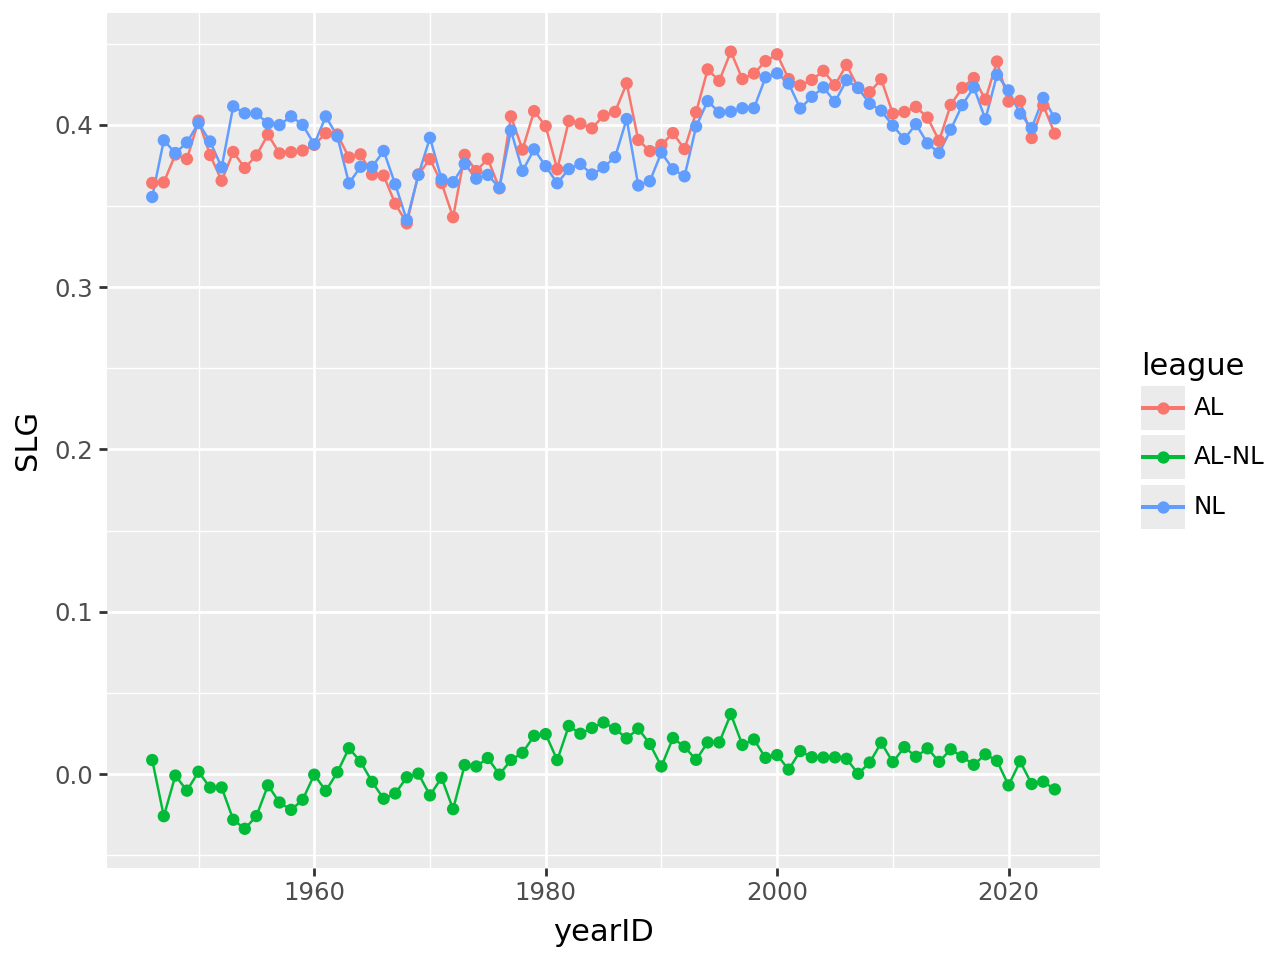

In [ ]:
# Making the basic plot
from plotnine import ggplot, aes, geom_line, geom_point

p_slg = ggplot(slg_pd, aes(x="yearID", y="SLG", color="league", group="league"))
p_slg = p_slg + geom_line()
p_slg = p_slg + geom_point()
p_slg


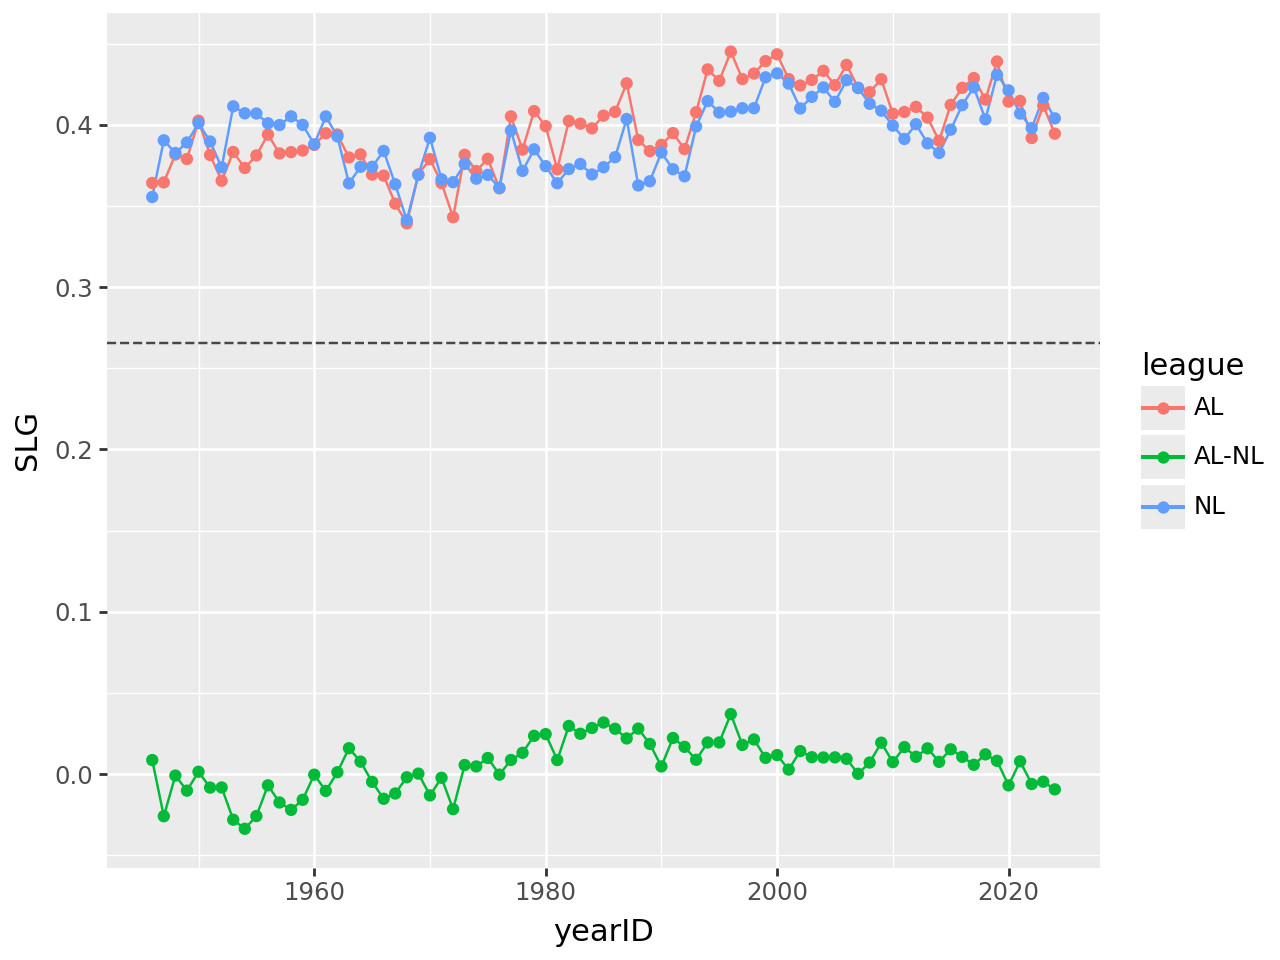

In [ ]:
# adding the horizontal mean line
from plotnine import geom_hline

p_slg = p_slg + geom_hline(yintercept=slg_mean, linetype="dashed", alpha=0.7)
p_slg


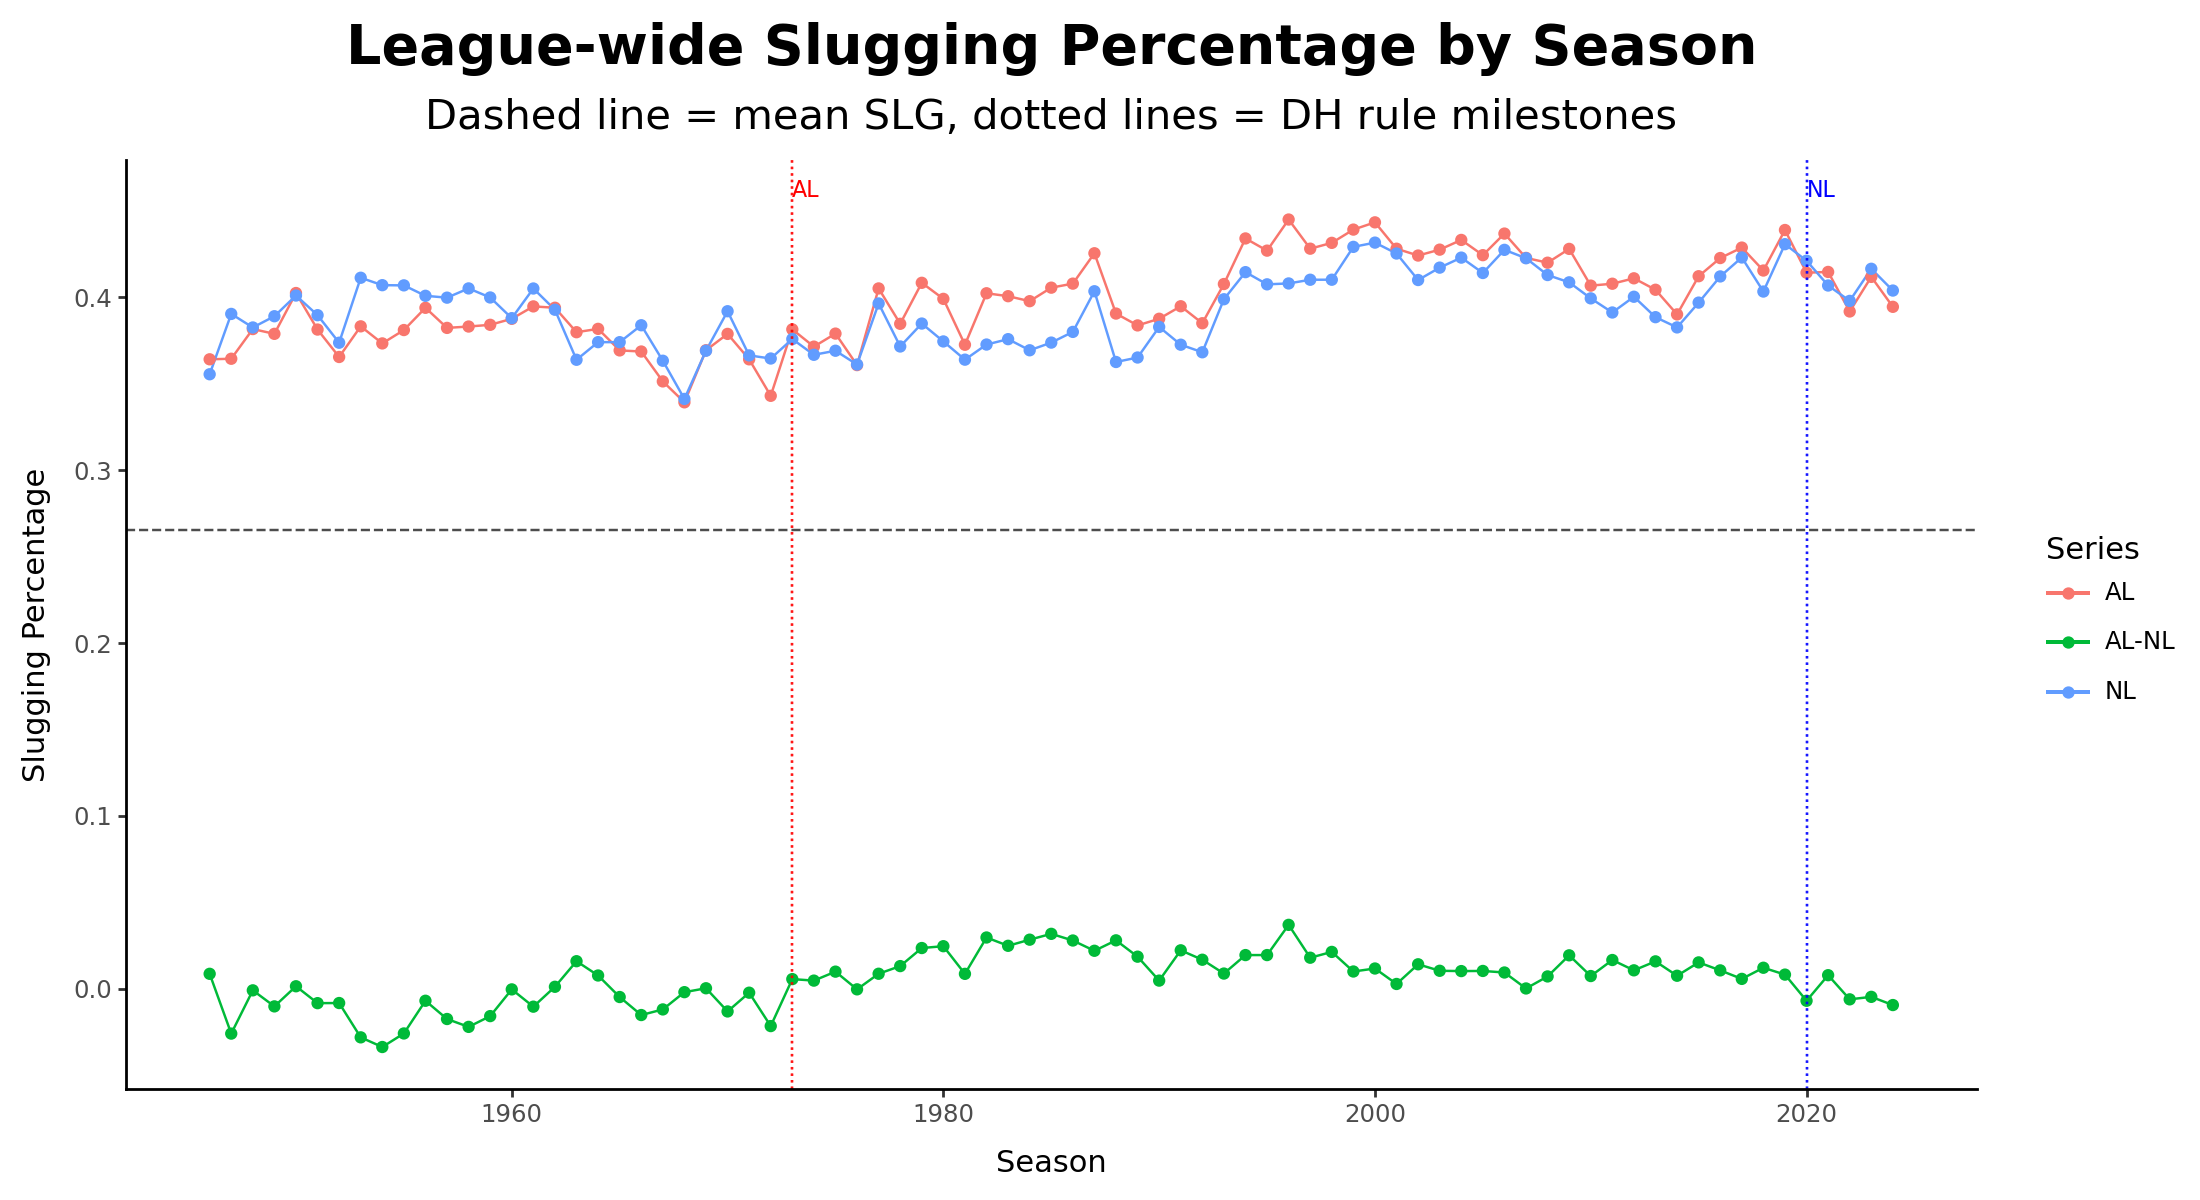

In [ ]:
# adding the vertical lines to indicate DH rule changes
from plotnine import geom_vline

# for AL line (1973) in red
p_slg = p_slg + geom_vline(xintercept=1973, linetype="dotted", alpha=0.7, color="red")

# for NL line (2020) in blue
p_slg = p_slg + geom_vline(xintercept=2020, linetype="dotted", alpha=0.7, color="blue")

p_slg


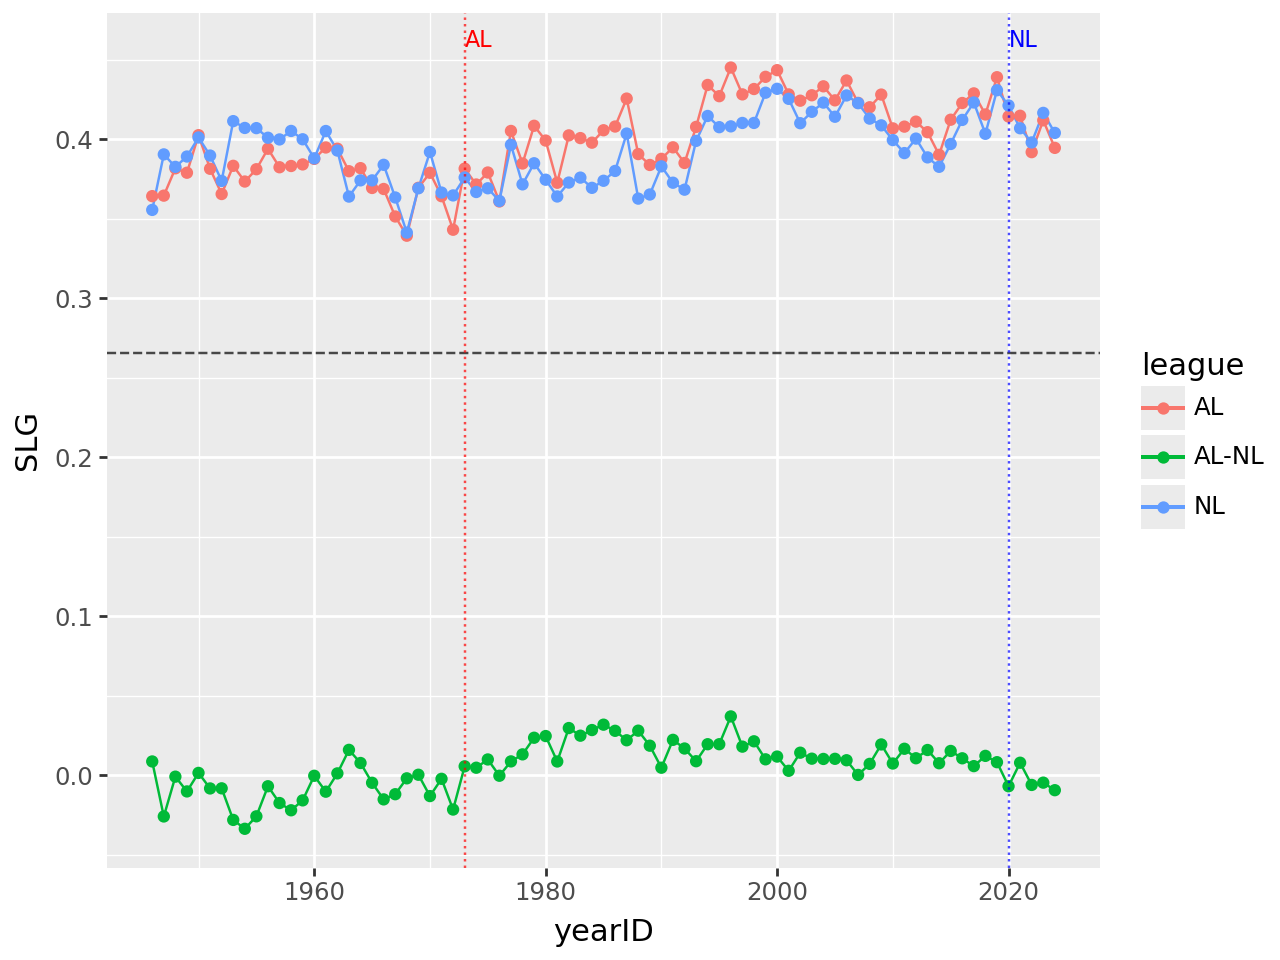

In [ ]:
# Addading annotations to indicate what the vertical lines and rule change
from plotnine import annotate

# adding the text labels for the vertical lines
p_slg = p_slg + annotate("text", x=1973, y=slg_ymax + 0.01,
                         label="AL", angle=0, color="Red", 
                         ha="left", va="bottom", size=8)
p_slg = p_slg + annotate("text", x=2020, y=slg_ymax + 0.01,
                         label="NL", angle=0, color="Blue",
                         ha="left", va="bottom", size=8)

p_slg


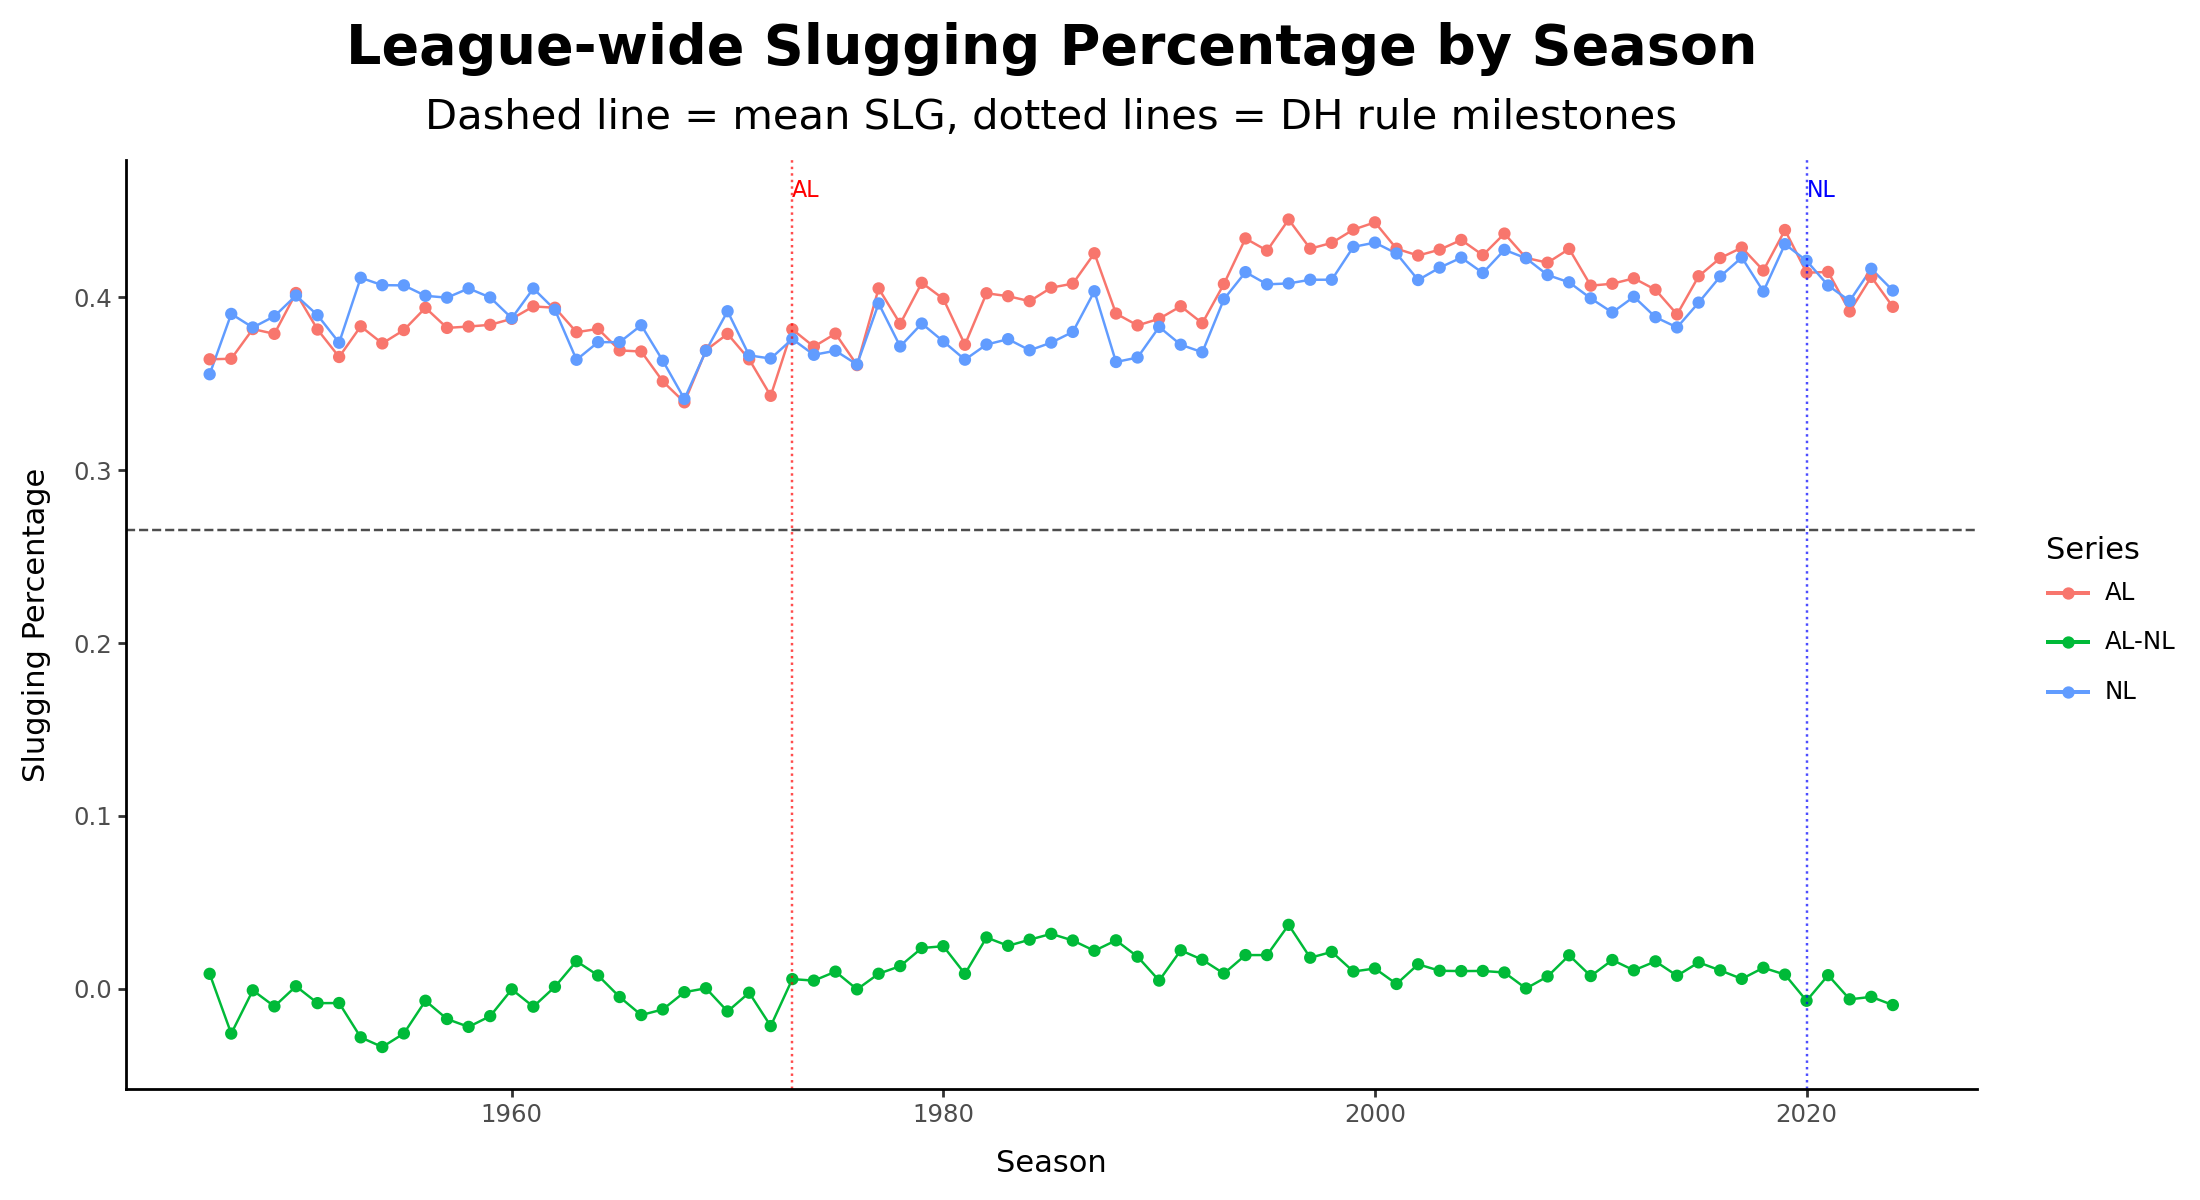

In [ ]:
# Adding labels and themes and size ratio   
from plotnine import labs, theme_classic, theme, element_text

p_slg = p_slg + labs(
    title="League-wide Slugging Percentage by Season", # changed the title to be more descriptive
    subtitle="Dashed line = mean SLG, dotted lines = DH rule milestones",
    x="Season",
    y="Slugging Percentage",
    color="Series"
)

p_slg = p_slg + theme_classic()
p_slg = p_slg + theme(
    figure_size=(11, 6),
    plot_title=element_text(ha="center", size=20, weight="bold"),
    plot_subtitle=element_text(ha="center", size=15)
)

p_slg



<h1>Task 4: 4.	Write each visualization to a PNG file stored in an img folder in the repository. (again, consult Google).</h1>

In [441]:
import os

# make sure the folder exists (safe check)
os.makedirs("image", exist_ok=True)

# save the ERA plot
p_era.save("image/ERA_plot.png", dpi=300)

# save the SLG plot
p_slg.save("image/SLG_plot.png", dpi=300)


c:\Users\im4284hw\AppData\Local\anaconda3\envs\polars\Lib\site-packages\plotnine\ggplot.py:630: PlotnineWarning: Saving 11 x 6 in image.
c:\Users\im4284hw\AppData\Local\anaconda3\envs\polars\Lib\site-packages\plotnine\ggplot.py:631: PlotnineWarning: Filename: image/ERA_plot.png
c:\Users\im4284hw\AppData\Local\anaconda3\envs\polars\Lib\site-packages\plotnine\ggplot.py:630: PlotnineWarning: Saving 11 x 6 in image.
c:\Users\im4284hw\AppData\Local\anaconda3\envs\polars\Lib\site-packages\plotnine\ggplot.py:631: PlotnineWarning: Filename: image/SLG_plot.png


In [442]:
# want to see the final data for ERA
era_long.head(10)


yearID,league,ERA
i64,str,f64
1946,"""AL""",4.098084
1946,"""AL-NL""",0.105
1946,"""NL""",3.993084
1947,"""AL""",4.193662
1947,"""AL-NL""",-0.458426
1947,"""NL""",4.652088
1948,"""AL""",4.786844
1948,"""AL-NL""",0.289993
1948,"""NL""",4.496851


In [443]:
# want to see the final data for SLG
slg_long.head(10)


yearID,league,SLG
i64,str,f64
1946,"""AL""",0.364142
1946,"""AL-NL""",0.008652
1946,"""NL""",0.35549
1947,"""AL""",0.364459
1947,"""AL-NL""",-0.025936
1947,"""NL""",0.390394
1948,"""AL""",0.381639
1948,"""AL-NL""",-0.00091
1948,"""NL""",0.382549
